In [40]:
import numpy as np
from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns 

In [20]:
df = pd.read_csv('TSLA.csv')

In [21]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3063,2022-08-29,282.829987,287.739990,280.700012,284.820007,284.820007,41864700
3064,2022-08-30,287.869995,288.480011,272.649994,277.700012,277.700012,50541800
3065,2022-08-31,280.619995,281.250000,271.809998,275.609985,275.609985,52107300
3066,2022-09-01,272.579987,277.579987,266.149994,277.160004,277.160004,54287000


In [22]:
train_dates = pd.to_datetime(df['Date'])

In [23]:
cols = list(df)[1:6] ## It wont include the volume column 

In [24]:
train_dates

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
3063   2022-08-29
3064   2022-08-30
3065   2022-08-31
3066   2022-09-01
3067   2022-09-02
Name: Date, Length: 3068, dtype: datetime64[ns]

In [25]:
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [26]:
df_for_training = df[cols].astype(float)

In [27]:
df_for_plot = df_for_training.tail(5000)

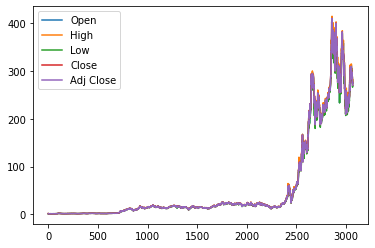

In [28]:
df_for_plot.plot.line()

In [29]:
scaler = StandardScaler() ##LSTM uses signoid and tanh that are sensitive to magnitude so values need to be normalized. So normalizing the dataset

In [30]:
scaler = scaler.fit(df_for_training)
df_for_training_scaled= scaler.transform(df_for_training)

In [31]:
df_for_training_scaled

array([[-0.57430027, -0.5700248 , -0.57593609, -0.5712028 , -0.5712028 ],
       [-0.56943668, -0.56623002, -0.57170017, -0.57124583, -0.57124583],
       [-0.57000254, -0.56938067, -0.57392844, -0.57258687, -0.57258687],
       ...,
       [ 2.42716295,  2.36620815,  2.40950803,  2.37639916,  2.37639916],
       [ 2.34077848,  2.32766503,  2.34707238,  2.3930727 ,  2.3930727 ],
       [ 2.43199802,  2.3777606 ,  2.37939321,  2.31831147,  2.31831147]])

In [32]:
trainX = [] ## this will be the value that we are inputting
trainY = [] ## this will be where we would predict for the future 

In [33]:
n_future = 1 ## for how many we want to predict
n_past = 14 ## number of past days we want to use to predict the future

In [34]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
  trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
  trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [35]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [36]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3054, 14, 5).
trainY shape == (3054, 1).


In [37]:
trainX

array([[[-0.57430027, -0.5700248 , -0.57593609, -0.5712028 ,
         -0.5712028 ],
        [-0.56943668, -0.56623002, -0.57170017, -0.57124583,
         -0.57124583],
        [-0.57000254, -0.56938067, -0.57392844, -0.57258687,
         -0.57258687],
        ...,
        [-0.57362697, -0.57247531, -0.57486239, -0.57407134,
         -0.57407134],
        [-0.57308259, -0.57261534, -0.57409022, -0.57353349,
         -0.57353349],
        [-0.57260267, -0.5719502 , -0.57345042, -0.57262272,
         -0.57262272]],

       [[-0.56943668, -0.56623002, -0.57170017, -0.57124583,
         -0.57124583],
        [-0.57000254, -0.56938067, -0.57392844, -0.57258687,
         -0.57258687],
        [-0.57143513, -0.57135508, -0.57507567, -0.57456616,
         -0.57456616],
        ...,
        [-0.57308259, -0.57261534, -0.57409022, -0.57353349,
         -0.57353349],
        [-0.57260267, -0.5719502 , -0.57345042, -0.57262272,
         -0.57262272],
        [-0.57225885, -0.57223025, -0.57409022, 

In [38]:
trainY

array([[-0.57225885],
       [-0.57311124],
       [-0.57322584],
       ...,
       [ 2.42716295],
       [ 2.34077848],
       [ 2.43199802]])

In [41]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(32, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(trainX, trainY, epochs = 10, batch_size = 16, validation_split = 0.1, verbose =1)

Epoch 1/10
172/172 [==============================] - 5s 15ms/step - loss: 0.0433 - val_loss: 0.1001
Epoch 2/10
172/172 [==============================] - 2s 12ms/step - loss: 0.0153 - val_loss: 0.4535
Epoch 3/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0158 - val_loss: 0.0906
Epoch 4/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0162 - val_loss: 0.0828
Epoch 5/10
172/172 [==============================] - 2s 12ms/step - loss: 0.0166 - val_loss: 0.1823
Epoch 6/10
172/172 [==============================] - 2s 12ms/step - loss: 0.0177 - val_loss: 0.2124
Epoch 7/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0143 - val_loss: 0.1466
Epoch 8/10
172/172 [==============================] - 2s 12ms/step - loss: 0.0120 - val_loss: 0.1150
Epoch 9/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0124 - val_loss: 0.0935
Epoch 10/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0107 - val_lo

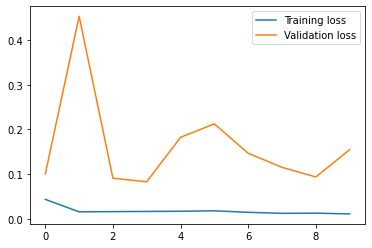

In [43]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [44]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [45]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

[Timestamp('2022-08-12 00:00:00', freq='C'), Timestamp('2022-08-15 00:00:00', freq='C'), Timestamp('2022-08-16 00:00:00', freq='C'), Timestamp('2022-08-17 00:00:00', freq='C'), Timestamp('2022-08-18 00:00:00', freq='C'), Timestamp('2022-08-19 00:00:00', freq='C'), Timestamp('2022-08-22 00:00:00', freq='C'), Timestamp('2022-08-23 00:00:00', freq='C'), Timestamp('2022-08-24 00:00:00', freq='C'), Timestamp('2022-08-25 00:00:00', freq='C'), Timestamp('2022-08-26 00:00:00', freq='C'), Timestamp('2022-08-29 00:00:00', freq='C'), Timestamp('2022-08-30 00:00:00', freq='C'), Timestamp('2022-08-31 00:00:00', freq='C'), Timestamp('2022-09-01 00:00:00', freq='C')]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


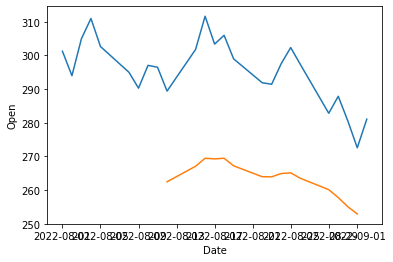

In [54]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-8-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])